# Definitions

## Import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yt
import seaborn as sns

plt.style.use('../plot_scripts/plot_style.mplstyle')

/home/hitesh/envs/mainenv/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/home/hitesh/envs/mainenv/lib/python3.9/site-packages/scipy/stats/_ksstats.py:74: RuntimeWarning: invalid value encountered in ldexp
  _EP128 = np.ldexp(np.longdouble(1), _E128)


In [2]:
from yt import derived_field

CONST_pc  = 3.086e18
CONST_yr  = 3.154e7
CONST_amu = 1.66053886e-24
CONST_kB  = 1.3806505e-16
unit_length = CONST_pc*1e3  # 1 kpc
unit_time   = CONST_yr*1e6  # 1 Myr
unit_density = CONST_amu    # 1 mp/cm-3
unit_velocity = unit_length/unit_time
KELVIN = unit_velocity*unit_velocity*CONST_amu/CONST_kB

g = 5/3
# T_floor = 10000.0
T_ceil = 1e8

X = 1.0
Y = 0.0
Z = 0.0

mu = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.)
mue = 2.0/(1.0+X)
muH = 1.0/X
mH = 1.0


# Temperature in Kelvin
@derived_field(name="temp", units="code_length**3*code_pressure/code_mass", \
    sampling_type="cell",force_override=True)
def _temp(field, data):
    return (data["gas", "pressure"] / data["gas", "density"]) * KELVIN * mu

In [3]:
def get_array(fn, MHD_flag = False):

    ds = yt.load(fn)

    all_data_level_0_hyd = ds.covering_grid(
        level=0, left_edge=[0, 0.0, 0.0], dims=ds.domain_dimensions
    )

    out_dict = {}

    x_arr = np.array(all_data_level_0_hyd[('gas','x')])
    y_arr = np.array(all_data_level_0_hyd[('gas','y')])
    z_arr = np.array(all_data_level_0_hyd[('gas','z')])

    r_arr = [x_arr,y_arr,z_arr]

    out_dict['coord'] = r_arr

    rho_arr  = np.array(all_data_level_0_hyd["density"])
    P_arr    = np.array(all_data_level_0_hyd["press"])
    T_arr    = np.array(all_data_level_0_hyd["temp"])
    
    out_dict['rho'] = rho_arr
    out_dict['T']   = T_arr
    out_dict['P']   = P_arr

    vel1_arr = np.array(all_data_level_0_hyd["vel1"])
    vel2_arr = np.array(all_data_level_0_hyd["vel2"])
    vel3_arr = np.array(all_data_level_0_hyd["vel3"])

    vel = [vel1_arr, vel2_arr, vel3_arr]

    out_dict['vel'] = vel

    if MHD_flag:
        Bcc1 = np.array(all_data_level_0_hyd["Bcc1"])
        Bcc2 = np.array(all_data_level_0_hyd["Bcc2"])
        Bcc3 = np.array(all_data_level_0_hyd["Bcc3"])

        Bcc = [Bcc1,Bcc2,Bcc3]

        out_dict['B'] = Bcc

    return out_dict

def get_array_user_var(fn, MHD_flag = False):

    ds = yt.load(fn)

    all_data_level_0_hyd = ds.covering_grid(
        level=0, left_edge=[0, 0.0, 0.0], dims=ds.domain_dimensions
    )

    out_dict = {}

    out_dict['user_out_var'] = np.array(all_data_level_0_hyd["user_out_var"])

    return 

## Class hst_data definitions

In [4]:
class hst_data:

    def __init__(self, fn, ncells, MHD_flag=False):

        """Read hst and return structured numpy dict.
        Keyword Arguments:
        fn -- 
        """

        hdr = []
        with open(fn, 'r') as fp:
            while True:
                l = fp.readline()
                if l[0] != '#':
                    raise Exception("No header in %s found!" %(fn))
                if '[1]' in l:
                    hdr = [i.split("=")[1].strip() for i in l[1:].split("[") if ']' in i]
                    break

        r = np.loadtxt(fn, dtype={'names' : hdr, 'formats' : len(hdr) * (float,)})

        self.dict = r

        self.time  = self.dict['time']
        self.dt    = self.dict['dt']

        self.mass_tot  = self.dict['mass']

        self.mom1  = self.dict['1-mom']
        self.mom2  = self.dict['2-mom']
        self.mom3  = self.dict['3-mom']

        self.KE1   = self.dict['1-KE']
        self.KE2   = self.dict['2-KE']
        self.KE3   = self.dict['3-KE']
        self.E_tot = self.dict['tot-E']

        self.cold_gas = self.dict['cold_gas']

        self.rho_avg    = self.dict['rho_sum']/ncells
        self.rho_sq_avg = self.dict['rho_sq_sum']/ncells

        self.cs_avg    = self.dict['c_s_sum']/ncells
        self.tcool_avg = self.dict['tcool_sum']/ncells

        if MHD_flag:

            self.Pth_avg = self.dict['Pth_sum']/ncells
            self.PB_avg  = self.dict['PB_sum']/ncells
            self.Bx_avg  = self.dict['Bx_sum']/ncells
            self.By_avg  = self.dict['By_sum']/ncells
            self.Bz_avg  = self.dict['Bz_sum']/ncells

            self.B_abs_avg = np.sqrt(self.PB_avg*2)
            self.dB = np.roll(self.B_abs_avg,-1) - self.B_abs_avg
            self.dt = self.time[1] - self.time[0]


        self.KE_tot = self.KE1+self.KE2+self.KE3
        self.turb_vel = np.sqrt(self.KE_tot*2/self.mass_tot)

        self.clumping_factor = self.rho_sq_avg/self.rho_avg**2
        self.cold_gas_fraction = self.cold_gas/self.mass_tot

        

        
        

yt : [WARNING  ] 2022-06-20 15:49:15,256 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2022-06-20 15:49:15,257 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2022-06-20 15:49:15,258 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2022-06-20 15:49:15,260 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2022-06-20 15:49:15,270 Parameters: current_time              = 0.40001436555473624
yt : [INFO     ] 2022-06-20 15:49:15,271 Parameters: domain_dimensions         = [ 64  64 640]
yt : [INFO     ] 2022-06-20 15:49:15,271 Parameters: domain_left_edge          = [ 0.     0.    -0.004]
yt : [INFO     ] 2022-06-20 15:49:15,272 Parameters: domain_right_edge         = [0.004 0.004 0.036]
yt : [INFO     ] 2022-06-20 15:49:15,274 Parameters: cosmological_simulation   = 0.0


[('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3'), ('athena_pp', 'press'), ('athena_pp', 'rho'), ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')]


yt : [INFO     ] 2022-06-20 15:49:16,181 xlim = -0.004000 0.036000
yt : [INFO     ] 2022-06-20 15:49:16,182 ylim = 0.000000 0.004000
yt : [INFO     ] 2022-06-20 15:49:16,182 xlim = -0.004000 0.036000
yt : [INFO     ] 2022-06-20 15:49:16,183 ylim = 0.000000 0.004000
yt : [INFO     ] 2022-06-20 15:49:16,185 Making a fixed resolution buffer of (('athena_pp', 'press')) 800 by 800
/afs/mpa/data/hitesh/envs/athenaenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/afs/mpa/data/hitesh/envs/athenaenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/afs/mpa/data/hitesh/envs/athenaenv/lib/python3.9/_collections_abc.py:941: Mat


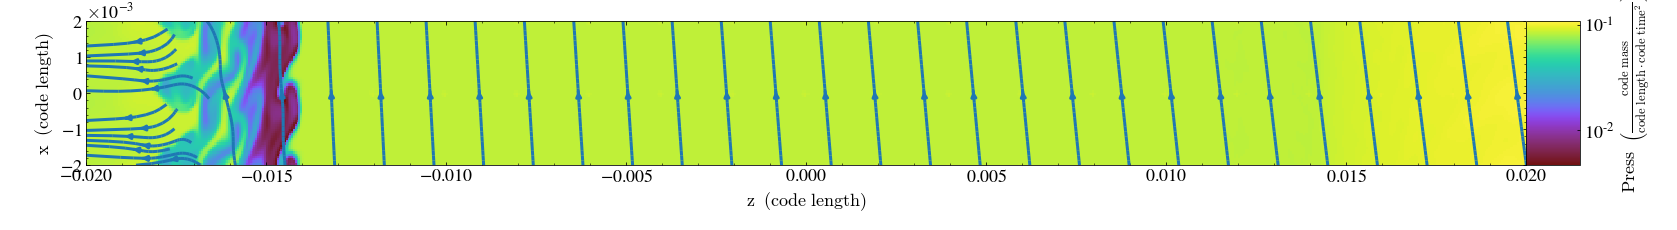

In [7]:
# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_sechs_Bx_cool_highB'
dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_zehn_Bx_cool_reflBC'
# dirname = 'test_elf_By_cool_reflBC'
# dirname = 'test_zwolf_Bz_cool_reflBC'
# dirname = 'test_dreizehn_hyd_cool_reflBC'

N = 10

file_name = dirname + f'/Turb.out2.{str(N).zfill(5)}.athdf'

# print(ps.out_dt_arr[3]/ps.t_eddy[3])

ds = yt.load(file_name)
print(ds.field_list)

# out_dict_2 = get_array_user_var(file_name)

# p = yt.ProjectionPlot(ds,axis='x',fields="Bcc3")
# p = yt.SlicePlot(ds,axis='y',fields="Bcc3")
p = yt.SlicePlot(ds,axis='y',fields="press")
# p.annotate_streamlines(('Bcc3'),('Bcc1'))
# p.annotate_streamlines(('Bcc2'),('Bcc3'))
p.annotate_streamlines(('vel3'),('vel1'))

p.set_figure_size(20)

# p.set_zlim("vel3",-1e-1,1e-1)
# p.set_zlim("temp",4e4,4*1e6)
# p.set_zlim("temp",1e5,2e5)
# p.set_zlim("Bcc3", 0.001, 0.04)
# p.set_zlim("press",5*1e-4, 1e-1)

# p.set_zlim("density",1e-1, 1e2)

# # p.save('../plot_scripts/magnetic_field_lines_Rlsh_100_res_128_beta_100.png')

p.show()


In [ ]:
import athena_read as ar

M_lim = 31

for M in range(M_lim):

        data_user = ar.athdf(dirname + f'/Turb.out4.{str(M).zfill(5)}.athdf')
        data_prim = ar.athdf(dirname + f'/Turb.out2.{str(M).zfill(5)}.athdf')

        temp = (data_prim['press'] / data_prim['rho']) * KELVIN * mu

        # print(np.shape(temp))
        # print(np.shape(data_user['user_out_var0']))

        # plt.figure()
        # plt.imshow(np.log10(data_user['user_out_var0'][:,32,:]))
        # plt.colorbar()

        x_arr = np.ravel(data_user['user_out_var0'])
        y_arr = np.ravel(temp)

        x_arr = np.log10(x_arr)
        y_arr = np.log10(y_arr)

        H, xedges, yedges = np.histogram2d(x_arr, y_arr, bins=1000)#, weights=out_dict_0['rho'])
        H = H.T

        plt.figure(figsize=(10,10))
        plt.imshow(np.log10(H), interpolation='nearest', origin='lower',
                extent=[-5, 1, 4.5, 6.6])

        plt.xlabel(r'log$_{10}$ tcool (Myr)')
        plt.ylabel(r'log$_{10}$ T (K)')

        plt.title(f'i: {M}')

        # plt.colorbar()
        plt.axhline(6, linestyle='dashed')

        plt.savefig(dirname + f'/Plots/T_tcool_{str(M).zfill(5)}.png')

        plt.close()

        print(M)
# plt.plot(hist_T[1][:-1], hist_T[0])
# plt.xscale('log')
# plt.yscale('log')

In [49]:
import os

# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_zehn_Bx_cool_reflBC'
# dirname = 'test_elf_By_cool_reflBC'
dirname = 'test_zwolf_Bz_cool_reflBC'
# dirname = 'test_dreizehn_hyd_cool_reflBC'

fig_save_dir = 'T'

cmd_mkdir = f'mkdir {dirname}/Plots/{fig_save_dir}'

os.system(cmd_mkdir)

M_lim = 30

for n in range(M_lim):

    file_name = dirname + f'/Turb.out2.{str(n).zfill(5)}.athdf'

    # print(ps.out_dt_arr[3]/ps.t_eddy[3])

    ds = yt.load(file_name)

    # p = yt.ProjectionPlot(ds,axis='x',fields="Bcc3")
    p = yt.SlicePlot(ds,axis='y',fields="temp")
    p.annotate_streamlines(('vel3'),('vel1'))

    p.set_figure_size(20)

    # p.set_zlim("press",5*1e-4, 1e-1)
    # p.set_zlim("vel3",-0.1,0.1)
#     p.set_zlim("vel3",0.001,0.1)
    # p.set_zlim("temp",4e4,4*1e6)
    p.set_zlim("temp",1e5,2e5)
    # p.set_zlim("density",1e-1, 1e2)

    p.save(dirname + f'/Plots/{fig_save_dir}/{fig_save_dir}_{str(n).zfill(5)}.png')

    # p.show()


yt : [WARNING  ] 2022-05-21 21:34:13,491 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2022-05-21 21:34:13,494 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2022-05-21 21:34:13,496 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2022-05-21 21:34:13,499 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2022-05-21 21:34:13,525 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-05-21 21:34:13,526 Parameters: domain_dimensions         = [ 64  64 640]
yt : [INFO     ] 2022-05-21 21:34:13,526 Parameters: domain_left_edge          = [ 0.   0.  -0.1]
yt : [INFO     ] 2022-05-21 21:34:13,528 Parameters: domain_right_edge         = [0.1 0.1 0.9]
yt : [INFO     ] 2022-05-21 21:34:13,529 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-05-21 21:34:20,911 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:34:20,914 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:34:20,918 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:34:20,928 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21

yt : [INFO     ] 2022-05-21 21:35:10,369 Parameters: domain_dimensions         = [ 64  64 640]
yt : [INFO     ] 2022-05-21 21:35:10,372 Parameters: domain_left_edge          = [ 0.   0.  -0.1]
yt : [INFO     ] 2022-05-21 21:35:10,374 Parameters: domain_right_edge         = [0.1 0.1 0.9]
yt : [INFO     ] 2022-05-21 21:35:10,375 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-05-21 21:35:17,799 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:35:17,802 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:35:17,807 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:35:17,808 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:35:17,812 Making a fixed resolution buffer of (('gas', 'temp')) 800 by 800
/home/hitesh/.local/lib/python3.9/site-packages/yt/visualization/base_plot_types.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please p

yt : [INFO     ] 2022-05-21 21:36:07,771 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-05-21 21:36:15,158 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:36:15,159 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:36:15,163 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:36:15,165 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:36:15,169 Making a fixed resolution buffer of (('gas', 'temp')) 800 by 800
/home/hitesh/.local/lib/python3.9/site-packages/yt/visualization/base_plot_types.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.image = self.axes.imshow(
yt : [INFO     ] 2022-05-21 21:36:22,876 Saving plot test_zwolf_Bz_cool_reflBC/Plots/T/T_00006.png
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarnin

yt : [INFO     ] 2022-05-21 21:37:13,144 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:37:13,147 Making a fixed resolution buffer of (('gas', 'temp')) 800 by 800
/home/hitesh/.local/lib/python3.9/site-packages/yt/visualization/base_plot_types.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.image = self.axes.imshow(
yt : [INFO     ] 2022-05-21 21:37:20,695 Saving plot test_zwolf_Bz_cool_reflBC/Plots/T/T_00009.png
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: Support for setting the 'mathtext.f

yt : [INFO     ] 2022-05-21 21:38:18,252 Saving plot test_zwolf_Bz_cool_reflBC/Plots/T/T_00012.png
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/hitesh/.local/lib/python3.9/site-packages/yt/visualization/base_plot_types.py:163: MatplotlibDeprecat

yt : [WARNING  ] 2022-05-21 21:39:19,364 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2022-05-21 21:39:19,369 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2022-05-21 21:39:19,375 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2022-05-21 21:39:19,380 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2022-05-21 21:39:19,410 Parameters: current_time              = 16.00022463100985
yt : [INFO     ] 2022-05-21 21:39:19,410 Parameters: domain_dimensions         = [ 64  64 640]
yt : [INFO     ] 2022-05-21 21:39:19,411 Parameters: domain_left_edge          = [ 0.   0.  -0.1]
yt : [INFO     ] 2022-05-21 21:39:19,412 Parameters: domain_right_edge         = [0.1 0.1 0.9]
yt : [INFO     ] 2022-05-21 21:39:19,415 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-05-21 21:39:26,657 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:39:26,659 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:39:26,664 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:39:26,667 ylim = 0.000000 0.100000
yt : [INFO   

yt : [INFO     ] 2022-05-21 21:40:17,105 Parameters: domain_dimensions         = [ 64  64 640]
yt : [INFO     ] 2022-05-21 21:40:17,105 Parameters: domain_left_edge          = [ 0.   0.  -0.1]
yt : [INFO     ] 2022-05-21 21:40:17,106 Parameters: domain_right_edge         = [0.1 0.1 0.9]
yt : [INFO     ] 2022-05-21 21:40:17,107 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-05-21 21:40:24,532 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:40:24,534 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:40:24,537 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:40:24,540 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:40:24,542 Making a fixed resolution buffer of (('gas', 'temp')) 800 by 800
/home/hitesh/.local/lib/python3.9/site-packages/yt/visualization/base_plot_types.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please p

yt : [INFO     ] 2022-05-21 21:41:15,578 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-05-21 21:41:22,943 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:41:22,947 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:41:22,951 xlim = -0.100000 0.900000
yt : [INFO     ] 2022-05-21 21:41:22,955 ylim = 0.000000 0.100000
yt : [INFO     ] 2022-05-21 21:41:22,958 Making a fixed resolution buffer of (('gas', 'temp')) 800 by 800
/home/hitesh/.local/lib/python3.9/site-packages/yt/visualization/base_plot_types.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.image = self.axes.imshow(
yt : [INFO     ] 2022-05-21 21:41:30,475 Saving plot test_zwolf_Bz_cool_reflBC/Plots/T/T_00022.png
/home/hitesh/miniconda3/envs/mainenv/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarnin

YTOutputNotIdentified: Supplied ('test_zwolf_Bz_cool_reflBC/Turb.out2.00023.athdf',) {}, but could not load!

In [50]:
# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_zehn_Bx_cool_reflBC'
# dirname = 'test_elf_By_cool_reflBC'
dirname = 'test_zwolf_Bz_cool_reflBC'
# dirname = 'test_dreizehn_hyd_cool_reflBC'

fig_save_dir = 'T'
framerate    = 5


cmd_cd    = f'cd {dirname}/Plots/{fig_save_dir}'
cmd_vid   = f'ffmpeg -framerate {framerate} -i {fig_save_dir}_%05d.png {fig_save_dir}.mp4'
cmd_fin   = f'cd ../../..'

command_list = [cmd_cd,cmd_vid,cmd_fin]

command = " && ".join(command_list)

print(command)

os.system(command)


cd test_zwolf_Bz_cool_reflBC/Plots/T && ffmpeg -framerate 5 -i T_%05d.png T.mp4 && cd ../../..


0

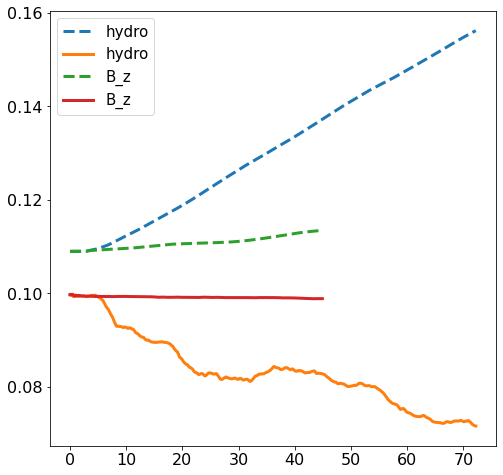

In [55]:
n1 = 64
n2 = 64
n3 = 320

# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_neun_hyd_cool'
dirname = 'test_dreizehn_hyd_cool_reflBC'

hst = hst_data(dirname+'/Turb.hst',ncells=n1*n2*n3)
plt.plot(hst.time,hst.mass_tot, linestyle='dashed', label='hydro')
plt.plot(hst.time,hst.cold_gas, label='hydro')

# dirname = 'test_sechs_Bx_cool'
# hst = hst_data(dirname+'/Turb.hst',ncells=n1*n2*n3)
# plt.plot(hst.time,hst.mass_tot, linestyle='dashed', label='B_x')
# plt.plot(hst.time,hst.cold_gas, label='B_x')

# dirname = 'test_seben_By_cool'
# hst = hst_data(dirname+'/Turb.hst',ncells=n1*n2*n3)
# plt.plot(hst.time,hst.mass_tot, linestyle='dashed', label='B_y')
# plt.plot(hst.time,hst.cold_gas, label='B_y')

# dirname = 'test_acht_Bz_cool'
dirname = 'test_zwolf_Bz_cool_reflBC'
hst = hst_data(dirname+'/Turb.hst',ncells=n1*n2*n3)
plt.plot(hst.time,hst.mass_tot, linestyle='dashed', label='B_z')
plt.plot(hst.time,hst.cold_gas, label='B_z')

# plt.xlim(0,51)

# plt.yscale('log')

plt.legend()

In [27]:
# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_seben_By_cool'
dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

N  = 0
dN = 1

file_name_0 = dirname + f'/Turb.out2.{str(N+0*dN).zfill(5)}.athdf'
file_name_1 = dirname + f'/Turb.out2.{str(N+1*dN).zfill(5)}.athdf'
file_name_2 = dirname + f'/Turb.out2.{str(N+2*dN).zfill(5)}.athdf'
file_name_3 = dirname + f'/Turb.out2.{str(N+3*dN).zfill(5)}.athdf'

MHD = True

out_dict_0 = get_array(file_name_0, MHD_flag=MHD)
out_dict_1 = get_array(file_name_1, MHD_flag=MHD)
out_dict_2 = get_array(file_name_2, MHD_flag=MHD)
out_dict_3 = get_array(file_name_3, MHD_flag=MHD)

yt : [ERROR    ] 2022-05-21 03:43:57,512 None of the arguments provided to load() is a valid file
yt : [ERROR    ] 2022-05-21 03:43:57,515 Please check that you have used a correct path


YTOutputNotIdentified: Supplied ('test_acht_Bz_cool/Turb.out2.00000.athdf',) {}, but could not load!

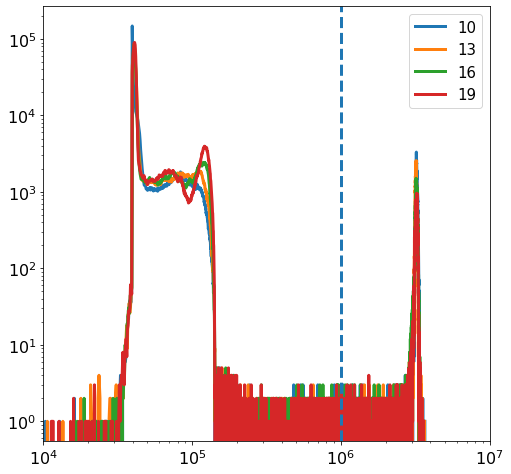

In [33]:
hist_T = np.histogram(out_dict_0['T'],bins=10000)#, weights=out_dict_0['rho'])
plt.plot(hist_T[1][:-1], hist_T[0], label=f'{N+0*dN}')

hist_T = np.histogram(out_dict_1['T'],bins=10000)#, weights=out_dict_1['rho'])
plt.plot(hist_T[1][:-1], hist_T[0], label=f'{N+1*dN}')

hist_T = np.histogram(out_dict_2['T'],bins=10000)#, weights=out_dict_2['rho'])
plt.plot(hist_T[1][:-1], hist_T[0], label=f'{N+2*dN}')

hist_T = np.histogram(out_dict_3['T'],bins=10000)#, weights=out_dict_3['rho'])
plt.plot(hist_T[1][:-1], hist_T[0], label=f'{N+3*dN}')

plt.xlim(1e4, 1e7)
# plt.xlim(1e-4, 1e-1)

plt.axvline(0.25*4000000, linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.legend()

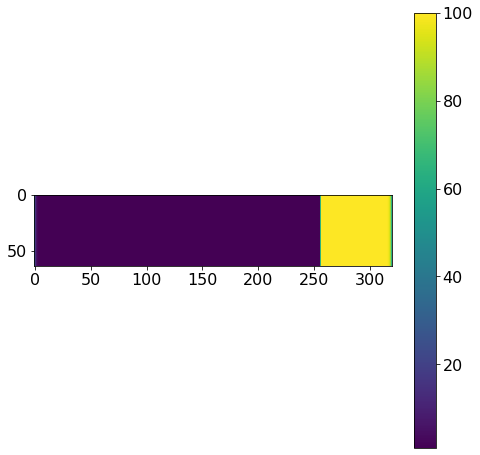

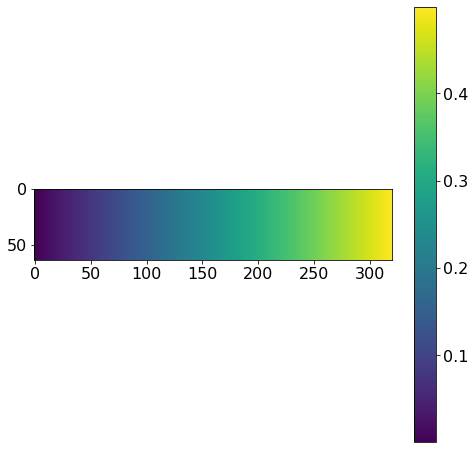

In [128]:
def arr_arrange(A):
    N = np.shape(A)[0]
    # A_2 = np.zeros_like(A)

    return np.flip(np.transpose(A),axis=0)

# plot_arr = out_dict_0['coord'][1][32,:,:]
plot_arr = out_dict_0['rho'][:,32,:]
# plot_arr = arr_arrange(plot_arr)
plt.figure()
plt.imshow(plot_arr)
plt.colorbar()


plot_arr = out_dict_0['coord'][2][:,32,:]
plt.figure()
plt.imshow(plot_arr)
plt.colorbar()

In [46]:
# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
dirname = 'test_neun_hyd_cool'

t_list   = []
mix_list = []

for N in range(25):
    file_name_0 = dirname + f'/Turb.out2.{str(N).zfill(5)}.athdf'
    out_dict_0 = get_array(file_name_0) #, MHD_flag=MHD)


    cond = np.logical_and(out_dict_0['T']>1e5, out_dict_0['T']<2e5)

    mix_mass = np.sum(out_dict_0['rho'][cond])

    # print(mix_mass)
    t_list.append(N)
    mix_list.append(np.sum(out_dict_0['rho'][cond]))

print

yt : [WARNING  ] 2022-05-19 14:44:29,211 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2022-05-19 14:44:29,212 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2022-05-19 14:44:29,213 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2022-05-19 14:44:29,214 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2022-05-19 14:44:29,225 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-05-19 14:44:29,226 Parameters: domain_dimensions         = [ 64  64 640]
yt : [INFO     ] 2022-05-19 14:44:29,227 Parameters: domain_left_edge          = [ 0.   0.  -0.1]
yt : [INFO     ] 2022-05-19 14:44:29,228 Parameters: domain_right_edge         = [0.1 0.1 0.9]
yt : [INFO     ] 2022-05-19 14:44:29,229 Parameters: cosmological_simulation   = 0.0
yt : [WARNING  ] 2022-05-19 14:44:33,820 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2022-05-19 14:44:33,823 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2022-05-19 14:44:33,826 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2022-05-19 14:44:33,829 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2022-05-19 14:44:33,848 Par

<function print>

In [18]:
import sys
sys.path.insert(0, '../vis/python')
import athena_read

# dirname = 'test_sechs_Bx_cool'
dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_zehn_Bx_cool_reflBC'
# dirname = 'test_elf_By_cool_reflBC'
# dirname = 'test_zwolf_Bz_cool_reflBC'
# dirname = 'test_dreizehn_hyd_cool_reflBC'

for n in range(100):
    file_name = dirname + f'/Turb.out4.{str(n).zfill(5)}.athdf'

    try:
        data = athena_read.athdf(file_name)
    except:
        break

    print(n)

    # print('x-bounds: {0} to {1}'.format(data['x1f'][10], data['x1f'][11]))
    # print('y-bounds: {0} to {1}'.format(data['x2f'][20], data['x2f'][21]))
    # print('z-bounds: {0} to {1}'.format(data['x3f'][30], data['x3f'][31]))

    emissivity = np.transpose(np.abs(data['user_out_var0'][:,:,32]))

    plt.figure(figsize=(40,5))
    plt.imshow(emissivity, cmap="inferno")#, vmax=5e-5, vmin=0)

    plt.colorbar()

    plt.savefig(dirname + f'/Plots/luminosity/lum_{str(n).zfill(5)}.png')

    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [26]:

import sys
sys.path.insert(0, '../vis/python')
import athena_read

# dirname = 'test_sechs_Bx_cool'
dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_zehn_Bx_cool_reflBC'
# dirname = 'test_elf_By_cool_reflBC'
# dirname = 'test_zwolf_Bz_cool_reflBC'
# dirname = 'test_dreizehn_hyd_cool_reflBC'

plot_what = 'vel3'

for n in range(100):
    file_name = dirname + f'/Turb.out2.{str(n).zfill(5)}.athdf'

    try:
        data = athena_read.athdf(file_name)
    except:
        break

    print(n)

    # print('x-bounds: {0} to {1}'.format(data['x1f'][10], data['x1f'][11]))
    # print('y-bounds: {0} to {1}'.format(data['x2f'][20], data['x2f'][21]))
    # print('z-bounds: {0} to {1}'.format(data['x3f'][30], data['x3f'][31]))

    plot_data = np.transpose(np.abs(data[plot_what][:,:,32]))

    # plot_data = np.log10(plot_data)

    # plot_data_min = -0.5
    # plot_data_max = 2.5

    plot_data_min = -0.2
    plot_data_max = 0.2

    plt.figure(figsize=(40,5))
    plt.imshow(plot_data, cmap="seismic", vmax=plot_data_max, vmin=plot_data_min)

    plt.colorbar()

    plt.savefig(dirname + f'/Plots/{plot_what}/{plot_what}_{str(n).zfill(5)}.png')

    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [15]:
import sys
sys.path.insert(0, '../vis/python')
import athena_read

# from numba import jit

# dirname = 'test_sechs_Bx_cool'
# dirname = 'test_seben_By_cool'
# dirname = 'test_acht_Bz_cool'
# dirname = 'test_neun_hyd_cool'

# dirname = 'test_zehn_Bx_cool_reflBC'
# dirname = 'test_elf_By_cool_reflBC'
# dirname = 'test_zwolf_Bz_cool_reflBC'
# dirname = 'test_dreizehn_hyd_cool_reflBC'

file_list = ['test_neun_hyd_cool','test_sechs_Bx_cool','test_seben_By_cool','test_acht_Bz_cool']
# file_list = ['test_neun_hyd_cool','test_sechs_Bx_cool_highB','test_seben_By_cool_highB','test_acht_Bz_cool_highB']

luminosity = []
time_list = []

B_x = []

ncells = 64*64*640

# @jit(nopython=True)
def lum_f (emissivity):
    return np.sum(emissivity)

# @jit(nopython=True)
def Bx_f (B, B0):
    return np.sqrt(np.sum((B - B0)**2))/ncells

def loop_func(fl, luminosity, B_x, time_list):

    for n in range(60):
        
        print(f'n: {n}')

        file_name = fl + f'/Turb.out4.{str(n).zfill(5)}.athdf'

        try:
            data = athena_read.athdf(file_name)
        except:
            break

        # emissivity = np.abs(data['user_out_var0'])

        emissivity = -1*(data['user_out_var0'])

        luminosity[i_fl].append(lum_f(emissivity))
        time_list[i_fl].append(n)

        file_name = fl + f'/Turb.out2.{str(n).zfill(5)}.athdf'

        try:
            data = athena_read.athdf(file_name)
        except:
            break

        if i_fl!=0:
            B_x[i_fl].append(Bx_f(data['Bcc1'],data0['Bcc1']))

    return luminosity, B_x, time_list


for i_fl,fl in enumerate(file_list):
    luminosity.append([0])
    time_list.append([0])
    B_x.append([0])

    print(f'i_fl: {i_fl}')

    file0 = fl + f'/Turb.out2.{str(0).zfill(5)}.athdf'
    data0 = athena_read.athdf(file0)
    
    luminosity, B_x, time_list = loop_func(fl, luminosity, B_x, time_list)


luminosity[0] = luminosity[0][1:]
time_list[0]  = time_list[0][1:]



i_fl: 0
n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
i_fl: 1
n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
i_fl: 2
n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 4

Text(0.5, 0, 'time (Myr)')

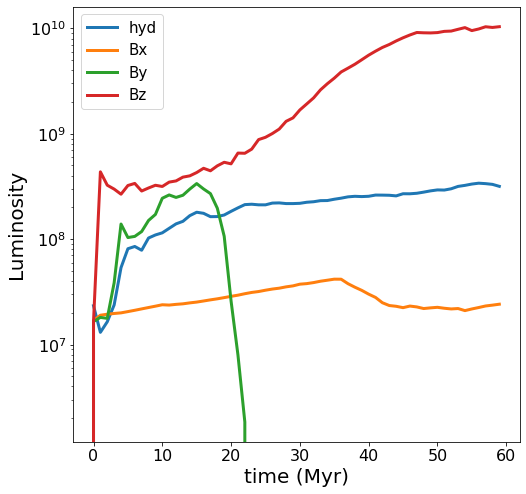

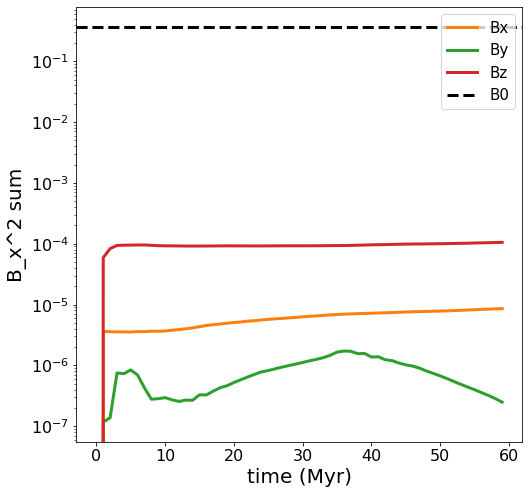

In [16]:
plt.figure()  
run_name = [fl.split('_')[2] for fl in file_list]

color_list = ['tab:blue', 'tab:orange','tab:green','tab:red']



for i_lum,lum in enumerate(luminosity):  
    plt.plot(time_list[i_lum], lum, label=run_name[i_lum],color=color_list[i_lum])

plt.legend()
plt.yscale('log')

plt.ylabel("Luminosity")
plt.xlabel("time (Myr)")

plt.figure()  

for i_B,Bx in enumerate(B_x):

    if i_B!=0:
        plt.plot(time_list[i_B], Bx, label=run_name[i_B], color=color_list[i_B])


plt.axhline(0.37, linestyle='dashed', color='k', label='B0')

plt.legend()
plt.yscale('log')

plt.ylabel("B_x^2 sum")
plt.xlabel("time (Myr)")

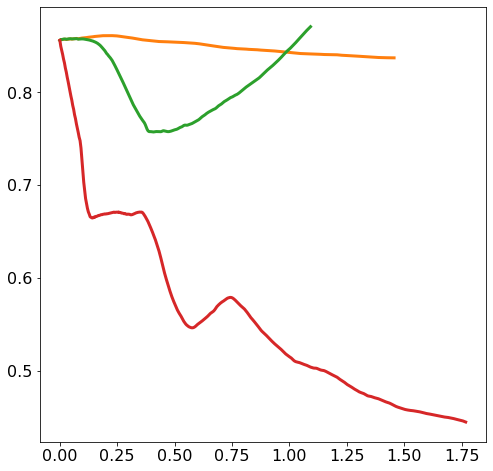

In [51]:
for i_fl,fl in enumerate(file_list):

    if i_fl !=0:

        file_name = fl + f'/Turb.hst'

        hst = hst_data(file_name, ncells=64*64*640, MHD_flag=True)

        plt.plot(hst.time, hst.Pth_avg/hst.PB_avg, color=color_list[i_fl], label=run_name[i_B])


(0.1, 2)

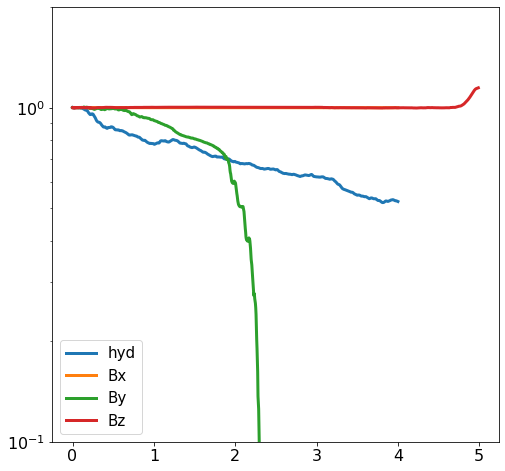

In [22]:
for i_fl,fl in enumerate(file_list):


    file_name = fl + f'/Turb.hst'

    if i_fl==0:
        hst = hst_data(file_name, ncells=64*64*640, MHD_flag=False)
    else:
        hst = hst_data(file_name, ncells=64*64*640, MHD_flag=True)

    plt.plot(hst.time, hst.cold_gas/hst.cold_gas[0], color=color_list[i_fl], label=run_name[i_fl])

plt.yscale('log')
plt.legend()
plt.ylim(1e-1,2)

In [86]:
n = 0

fl = 'test_acht_Bz_cool'

file_name = fl + f'/Turb.out2.{str(n).zfill(5)}.athdf'

data = athena_read.athdf(file_name)

v1 = data['vel1']
v2 = data['vel2']
v3 = data['vel3']

B1 = data['Bcc1']
B2 = data['Bcc2']
B3 = data['Bcc3']

P = data['press']

v_mag = np.sqrt(v1*v1 + v2*v2 + v3*v3)
B_mag = np.sqrt(B1*B1 + B2*B2 + B3*B3)

rho = data['rho']

va = B_mag/rho

Ma = v_mag/va

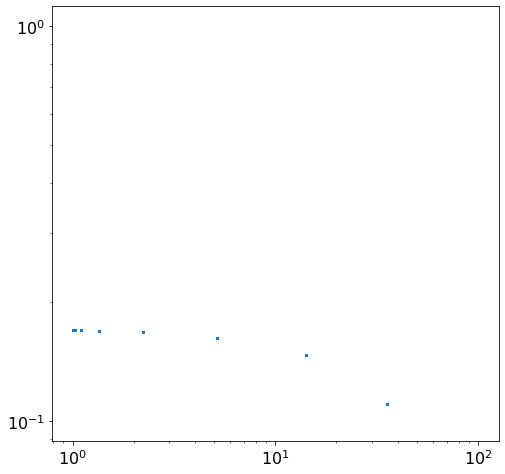

In [84]:
plt.scatter(rho, v_mag, s=1)

# plt.axhline(1, linestyle='dashed', color='k')

plt.xscale('log')
plt.yscale('log')

# plt.xlim(0.5,200)
# plt.ylim(1e-2,5e1)

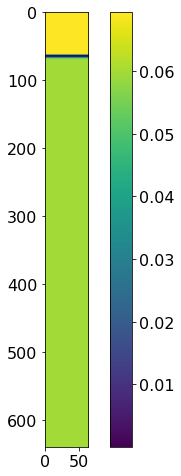

In [92]:
plt.imshow(P[:,:,32])
plt.colorbar()